Code adapted from https://huggingface.co/docs/transformers/training

In [ ]:
!pip install transformers==4.0.0
!pip install tensorflow
!pip install keras
!pip install Sentencepiece
!pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install datasets

In [2]:
import transformers
import torch
import keras
from datasets import load_dataset

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

#### Comment in/out depending on which test should be run

In [ ]:
vals_ds_bin = load_dataset('csv', data_files="sublabel_train_balanced.csv", split=[
    f'train[{k}%:{k+10}%]' for k in range(0, 100, 10)
])
trains_ds_bin = load_dataset('csv', data_files="sublabel_train_balanced.csv", split=[
    f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)
])

'''vals_ds_bin = load_dataset('csv', data_files="sublabel_most_active_train_balanced.csv", split=[
    f'train[{k}%:{k+10}%]' for k in range(0, 100, 10)
])
trains_ds_bin = load_dataset('csv', data_files="sublabel_most_active_train_balanced.csv", split=[
    f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 10)
])

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True)

for index, val_ds in enumerate(vals_ds_bin):
    val_ds = val_ds.remove_columns(["Unnamed: 0"])
    vals_ds_bin[index] = val_ds.map(tokenize_function, batched=True)
    
for index, train_ds in enumerate(trains_ds_bin):
    train_ds = train_ds.remove_columns(["Unnamed: 0"])
    trains_ds_bin[index] = train_ds.map(tokenize_function, batched=True)

In [5]:
from transformers import AutoModelForSequenceClassification

In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer", evaluation_strategy="epoch")

In [7]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix#, plot_confusion_matrix

def compute_metrics(pred):
    logits, labels = pred
    preds_bin = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds_bin, average='macro')
    acc = accuracy_score(labels, preds_bin)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [ ]:
from transformers import Trainer

metrics = {}

for i in range(10):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=4)
    trainer = Trainer(model=model, args=training_args, train_dataset=trains_ds_bin[i], eval_dataset=vals_ds_bin[i], compute_metrics=compute_metrics)
    trainer.train()
    metrics[i] = trainer.evaluate()
    
    

In [9]:
metrics_df = pd.DataFrame.from_dict(metrics).transpose()
metrics_df.describe()

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,epoch
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.879274,0.780959,0.794310,0.796602,0.803433,3.0
std,0.163435,0.029416,0.025975,0.031033,0.023209,0.0
min,0.699378,0.733945,0.747783,0.737973,0.763123,3.0
25%,0.745488,0.765909,0.775470,0.775365,0.789881,3.0
50%,0.861071,0.789950,0.801419,0.801116,0.798835,3.0
75%,0.932285,0.799541,0.812273,0.811263,0.822845,3.0
max,1.183101,0.818182,0.828518,0.837884,0.837281,3.0


#### Comment in/out depending on training set

In [ ]:
test = load_dataset('csv', data_files="sublabel_test.csv")
#test = load_dataset('csv', data_files="sublabel_least_active_test.csv")

test = test.remove_columns(["Unnamed: 0"])
test = test.map(tokenize_function, batched=True)

In [11]:
#redefining compute_metrics function to fit trainer.predict returns
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

y_pred = trainer.predict(test["train"])
compute_metrics(y_pred)

{'accuracy': 0.7006578947368421,
 'f1': 0.6669126814078958,
 'precision': 0.6284293191289778,
 'recall': 0.7470470306855452}

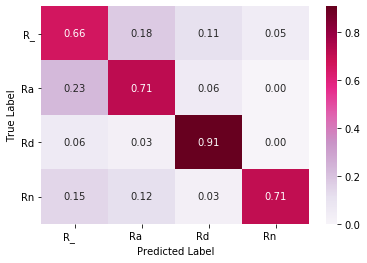

In [13]:
# Code adapted from https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="PuRd")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');

class_names=["R_", "Ra", "Rd", "Rn"]

cm = confusion_matrix(y_pred.label_ids, y_pred.predictions.argmax(-1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)